<a href="https://colab.research.google.com/github/MhamedBendenia/ArcGIS-COVID-19/blob/master/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
%cd /content/drive/My Drive/COVID-19
%rm -r *
!pip install arcgis
!pip install geopandas
!pip install contextily==1.0rc2
!pip install pyunpack
!pip install patool
!apt-get -qq install python-cartopy python3-cartopy

!rm -r COVID-19
!git clone https://github.com/CSSEGISandData/COVID-19.git

/content/drive/My Drive/COVID-19
rm: cannot remove 'COVID-19': No such file or directory
Cloning into 'COVID-19'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 2871 (delta 83), reused 148 (delta 44), pack-reused 2683
Receiving objects: 100% (2871/2871), 30.75 MiB | 20.91 MiB/s, done.
Resolving deltas: 100% (1546/1546), done.


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as ctx
import requests
import cartopy

from pyunpack import Archive
from shapely.geometry import Point, Polygon , MultiPolygon
from arcgis import GIS
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
 

In [0]:
df_confirmed = pd.read_csv("./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")
df_deaths = pd.read_csv("./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
df_recovred = pd.read_csv("./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")

In [0]:
df_confirmed = df_confirmed.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"})
df_deaths = df_deaths.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"})
df_recovred = df_recovred.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"})

In [0]:
df_confirmed.Province_State.fillna(value=df_confirmed.Country_Region, inplace=True)
df_deaths.Province_State.fillna(value=df_deaths.Country_Region, inplace=True)
df_recovred.Province_State.fillna(value=df_recovred.Country_Region, inplace=True)

df_confirmed.Country_Region.replace({"US": "United States", "Others": "Japan", "Hong Kong": "China", "Mainland China": "China", "Macau": "China", "North Macedonia": "Macedonia", "UK": "United Kingdom"}, inplace=True)
df_deaths.Country_Region.replace({"US": "United States", "Others": "Japan", "Hong Kong": "China", "Mainland China": "China", "Macau": "China", "North Macedonia": "Macedonia", "UK": "United Kingdom"}, inplace=True)
df_recovred.Country_Region.replace({"US": "United States", "Others": "Japan", "Hong Kong": "China", "Mainland China": "China", "Macau": "China", "North Macedonia": "Macedonia", "UK": "United Kingdom"}, inplace=True)

In [0]:
df_confirmed = df_confirmed.groupby(["Province_State",	"Country_Region", "Lat",	"Long"]).sum().stack().to_frame()
df_deaths = df_deaths.groupby(["Province_State",	"Country_Region", "Lat",	"Long"]).sum().stack().to_frame()
df_recovred = df_recovred.groupby(["Province_State",	"Country_Region", "Lat",	"Long"]).sum().stack().to_frame()

In [0]:
df_confirmed.index.names = ["Province_State",	"Country_Region", "Lat",	"Long", "Date"]
df_deaths.index.names = ["Province_State",	"Country_Region", "Lat",	"Long", "Date"]
df_recovred.index.names = ["Province_State",	"Country_Region", "Lat",	"Long", "Date"]

In [0]:
df_cases = df_confirmed.merge(df_deaths, on=["Province_State",	"Country_Region", "Lat",	"Long", "Date"]).merge(df_recovred, on=["Province_State",	"Country_Region", "Lat",	"Long", "Date"])
df_cases.columns = ["Confirmed", "Deaths", "Recovred"]

In [0]:
df_cases.reset_index(inplace= True)
df_cases["Date"] = df_cases['Date'].astype('datetime64')
gdf_cases = gpd.GeoDataFrame(df_cases, geometry=gpd.points_from_xy(df_cases.Long, df_cases.Lat), crs="epsg:4326")
gdf_cases.Date = gdf_cases.Date.apply(lambda t: str(t)[0:11])
gdf_cases.to_file('./covid_cases')

In [0]:
#map plot
# ctx.add_basemap(gdf_cases.plot(figsize=(20, 20)), url=ctx.providers.OpenStreetMap.France, crs="EPSG:4326")

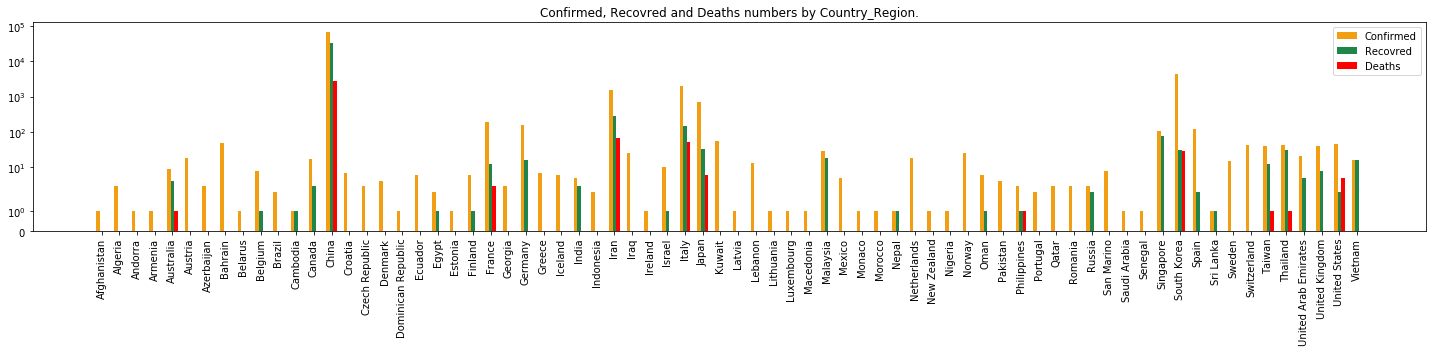

In [59]:
# graph plots
df_temp = df_cases.groupby("Country_Region")["Confirmed", "Deaths", "Recovred"].max().reset_index()

ind = np.arange(df_temp.Country_Region.count())    # the x locations for the groups

f, ax = plt.subplots(figsize=(20,5))

p1 = ax.bar(ind-0.20, df_temp.Confirmed, 0.20 ,color=(0.95, 0.62, 0.07, 1))
p2 = ax.bar(ind, df_temp.Recovred, 0.20, color=(0.12, 0.52, 0.29, 1))
p3 = ax.bar(ind+0.20, df_temp.Deaths, 0.20, color=(1, 0, 0, 1))

ax.set_title('Confirmed, Recovred and Deaths numbers by Country_Region.')
plt.xticks(ind, df_temp.Country_Region)
plt.xticks(rotation=90)
ax.set_yscale('symlog')
ax.legend((p1[0], p2[0], p3[0]), ('Confirmed', 'Recovred', 'Deaths'))
plt.tight_layout()
plt.savefig("bar.png")
plt.show()


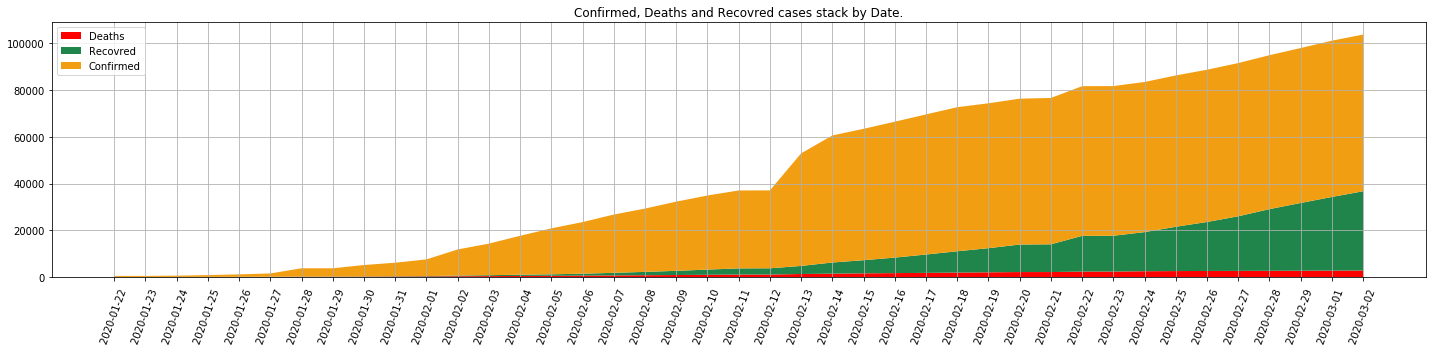

In [60]:
# stackplot
df_temp = df_cases.groupby("Date")["Confirmed", "Deaths", "Recovred"].max().reset_index()

fig, ax = plt.subplots(figsize=(20,5))
plt.grid()
ax.stackplot(df_temp.Date.values, df_temp.Deaths.values, df_temp.Recovred.values, df_temp.Confirmed.values, labels=["Deaths", "Recovred", "Confirmed"], colors=[(1, 0, 0, 1), (0.12, 0.52, 0.29, 1), (0.95, 0.62, 0.07, 1)])
ax.legend(loc=2)
plt.title("Confirmed, Deaths and Recovred cases stack by Date.")
plt.xticks(rotation=70)
plt.tight_layout()
plt.savefig("stack.png")
plt.show()

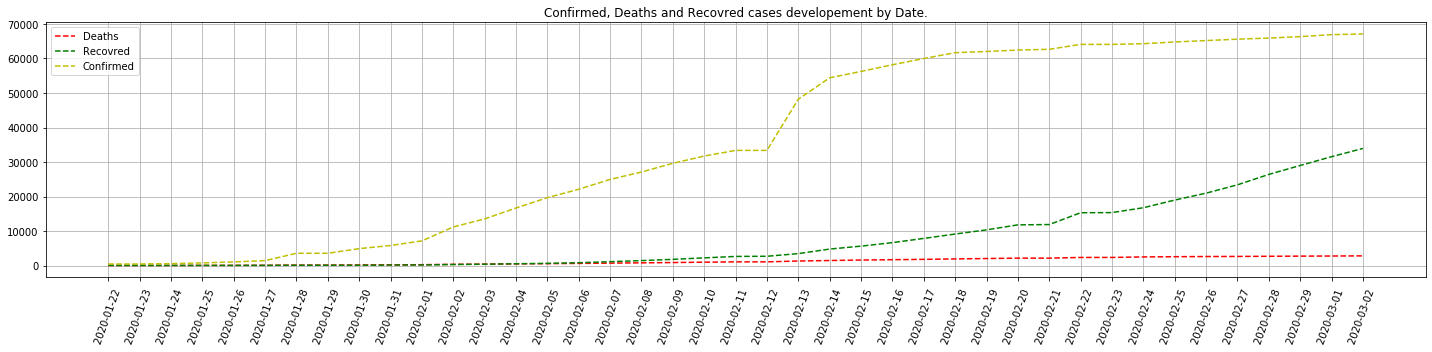

In [61]:
# lineplot
df_temp = df_cases.groupby("Date")["Confirmed", "Deaths", "Recovred"].max().reset_index()

fig, ax = plt.subplots(figsize=(20,5))
plt.grid()
ax.plot(df_temp.Date.values, df_temp.Deaths.values, 'r--', label="Deaths")
ax.plot(df_temp.Date.values, df_temp.Recovred.values, 'g--', label="Recovred")
ax.plot(df_temp.Date.values, df_temp.Confirmed.values, 'y--', label="Confirmed")

ax.legend(loc=2)
plt.title("Confirmed, Deaths and Recovred cases developement by Date.")
plt.xticks(rotation=70)
plt.tight_layout()
plt.savefig("lineplot.png")
plt.show()

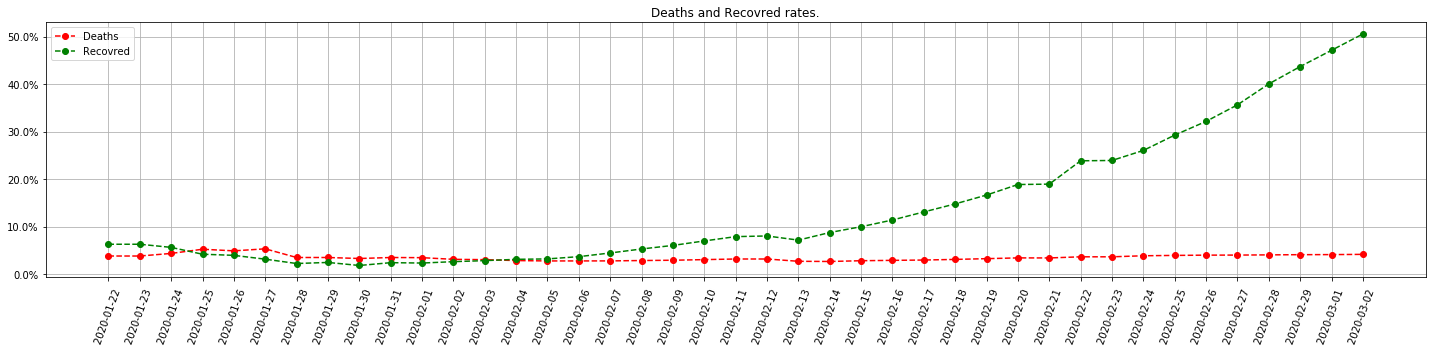

In [62]:
# lineplot
df_temp = df_cases.groupby("Date")["Confirmed", "Deaths", "Recovred"].max().reset_index()

fig, ax = plt.subplots(figsize=(20,5))

plt.grid()
ax.plot(df_temp.Date.values, df_temp.Deaths.values / df_temp.Confirmed.values, 'r--', marker="o", label="Deaths")
ax.plot(df_temp.Date.values, df_temp.Recovred.values / df_temp.Confirmed.values, 'g--', marker="o", label="Recovred")

ax.legend(loc=2)
plt.title("Deaths and Recovred rates.")
ax.set_yticklabels(['{:.1f}%'.format(x*100) for x in ax.get_yticks()])
plt.xticks(rotation=70)
plt.tight_layout()
plt.savefig("rate.png")
plt.show()

In [0]:
url = 'https://tapiquen-sig.jimdofree.com/app/download/5496966159/World_Countries.rar?t=1423138641'
myfile = requests.get(url)
open('/content/world.rar', 'wb').write(myfile.content)
%mkdir world
Archive('/content/world.rar').extractall('./world')

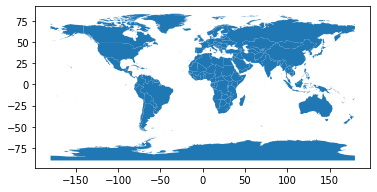

In [18]:
world_shp = gpd.read_file("./world/World_Countries.shp")
world_shp.columns = ['Country_Region', 'geometry']
world_shp.plot()

In [0]:
date_world_cases = world_shp.merge(gdf_cases, on='Country_Region', suffixes=("", "_point"))

date_world_cases.drop(labels=["Province_State",	"Lat",	"Long", "geometry_point"], axis=1, inplace=True)
date_world_cases.drop(date_world_cases[(date_world_cases.Confirmed == 0) & (date_world_cases.Recovred == 0) & (date_world_cases.Deaths == 0)].index, inplace=True)

date_world_cases.sort_values(by=["Date", "Confirmed",	"Deaths",	"Recovred"], inplace=True)
date_world_cases.drop_duplicates(subset=["Country_Region", "Date"], inplace=True, keep='last')
date_world_cases.sort_values(by=["Date"], inplace=True)
date_world_cases.drop_duplicates(subset=["Country_Region", "Confirmed",	"Deaths",	"Recovred"], inplace=True, keep='last')

date_world_cases.to_file("./date_world_cases")

In [0]:
world_cases = world_shp.merge(gdf_cases, on='Country_Region', suffixes=("", "_point"), how = 'outer')
world_cases.sort_values(by=["Confirmed", "Deaths", "Recovred"], inplace=True)
world_cases = world_cases.groupby(["Country_Region"])["geometry","Confirmed", "Deaths", "Recovred"].last()
world_cases.reset_index(inplace=True)

g=gpd.GeoDataFrame(world_cases)
g.to_file("./world_cases")

In [21]:
!zip -r COVID-19.zip date_world_cases world_cases covid_cases
%rm -r date_world_cases world_cases covid_cases COVID-19 world

  adding: date_world_cases/ (stored 0%)
  adding: date_world_cases/date_world_cases.shp (deflated 56%)
  adding: date_world_cases/date_world_cases.shx (deflated 37%)
  adding: date_world_cases/date_world_cases.dbf (deflated 96%)
  adding: date_world_cases/date_world_cases.cpg (stored 0%)
  adding: date_world_cases/date_world_cases.prj (deflated 15%)
  adding: world_cases/ (stored 0%)
  adding: world_cases/world_cases.shp (deflated 57%)
  adding: world_cases/world_cases.shx (deflated 27%)
  adding: world_cases/world_cases.dbf (deflated 93%)
  adding: world_cases/world_cases.cpg (stored 0%)
  adding: covid_cases/ (stored 0%)
  adding: covid_cases/covid_cases.shp (deflated 91%)
  adding: covid_cases/covid_cases.shx (deflated 72%)
  adding: covid_cases/covid_cases.dbf (deflated 98%)
  adding: covid_cases/covid_cases.cpg (stored 0%)
  adding: covid_cases/covid_cases.prj (deflated 15%)
